# Challenge: The Boston marathon

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

My goal here was to learn something about these runners comparatively. 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from itertools import cycle

In [2]:
url = r'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv'
data = pd.read_csv(url)

In [3]:
# making all column names lowercase
data.columns = map(str.lower, data.columns)
non_numeric_columns = data.select_dtypes(['object']).columns
numeric_columns = data.select_dtypes(['int64', 'float64']).columns

In [4]:
total_missing = data.isnull().sum().sort_values(ascending=False)
percent_missing = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
ctz,30740,0.961106
state,2576,0.080540
city,1,0.000031


## Data Cleaning & data info

    * ##k are mile markers 
    * bib is runner id
    * ctz will be dropped due to lack of information 
    * state will be dropped out of convinence bcuz we have city
    * also dropping the one missing observation without city defined
    * casting numerical values to floats


In [5]:
bib = data.bib
data = data.drop(['state', 'ctz', 'bib'], axis=1)
data = data.dropna()

In [6]:
def num_er(df):
    for x in ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']:
        data.drop(data[data[x] == '-'].index, inplace = True, axis=0)
        data[x] = data[[x]].astype(float)
    return df
data = num_er(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31648 entries, 0 to 31983
Data columns (total 18 columns):
10k          31648 non-null float64
name         31648 non-null object
division     31648 non-null int64
25k          31648 non-null float64
gender       31648 non-null object
age          31648 non-null int64
official     31648 non-null float64
genderdiv    31648 non-null int64
35k          31648 non-null float64
overall      31648 non-null int64
pace         31648 non-null float64
30k          31648 non-null float64
5k           31648 non-null float64
half         31648 non-null float64
20k          31648 non-null float64
country      31648 non-null object
city         31648 non-null object
40k          31648 non-null float64
dtypes: float64(10), int64(4), object(4)
memory usage: 4.6+ MB


In [7]:
non_numeric_columns = data.select_dtypes(['object']).columns
numeric_columns = data.select_dtypes(['int64', 'float64']).columns

In [8]:
non_numeric_columns

Index(['name', 'gender', 'country', 'city'], dtype='object')

In [9]:
numeric_columns

Index(['10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k',
       'overall', 'pace', '30k', '5k', 'half', '20k', '40k'],
      dtype='object')

In [10]:
data.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000
mean,51.629090,1922.800367,133.581381,42.384700,241.952878,8003.025404,196.033725,15834.008658,9.236483,163.895155,25.678275,111.211631,105.321547,228.190455
std,8.710235,1704.844465,25.571858,11.299784,50.843279,4733.295012,40.775632,9182.364552,1.939178,32.889838,4.215447,20.306691,19.159786,48.075181
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.370000,607.000000,115.430000,33.000000,205.300000,3940.000000,166.950000,7879.750000,7.830000,140.515000,22.620000,96.750000,91.670000,193.620000
50%,50.280000,1418.000000,128.850000,42.000000,231.980000,7919.000000,187.850000,15829.500000,8.850000,157.500000,25.050000,107.680000,102.000000,218.475000
75%,57.000000,2601.000000,147.700000,50.000000,272.200000,11893.000000,219.370000,23785.250000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


## Avg Age 42
## Avg Pace 9.23
## std increases as we get further along the race
## checked out youtube video on the marathon, there are specific areas that runners are challenged more than other areas of the course

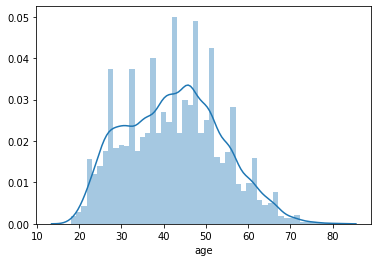

In [11]:
sns.distplot(data['age'])


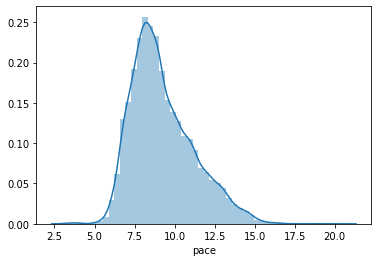

In [12]:
sns.distplot(data['pace'])

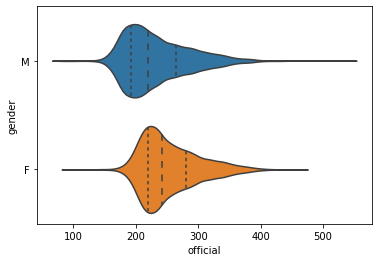

In [13]:
sns.violinplot(x="official", y="gender",
               split=True, inner="quart",
               data=data)

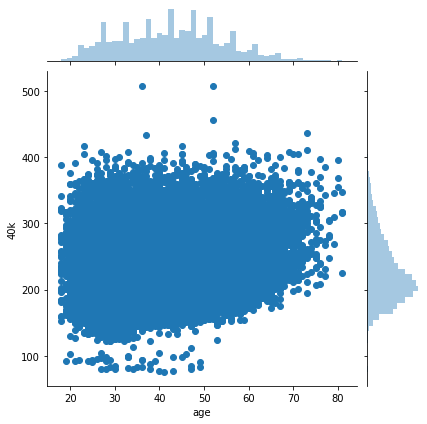

In [14]:
sns.jointplot(x="age", y="40k", data=data)

In [15]:
data = pd.get_dummies(data, columns=['gender'])
data = data.drop(['gender_F'], axis=1)

In [16]:
X = data[['gender_M', 'pace']].values
y = data[['official']].values

# K-Means

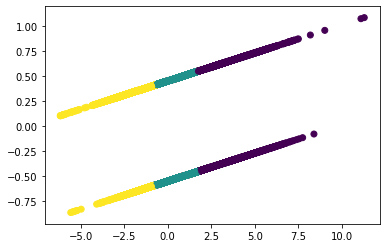

In [17]:
# Normalize the data.
     # because this data was generated abitrarily we do not need to normalize it for this excersize
          # using X_norm gives us a really cool shape!!!
X_norm = normalize(X)

# Reduce it to two components for visualization
X_pca = PCA(2).fit_transform(X)

# We know we're looking for three clusters.

# Calculate predicted values.
Kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++').fit(X_pca)
y_pred = Kmeans.predict(X_pca)
labels = Kmeans.labels_

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

### Calinski-Harabasz Index
If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.


2.3.10.6.1. Advantages
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

The score is fast to compute.

2.3.10.6.2. Drawbacks
The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [18]:
score = metrics.calinski_harabasz_score(X, labels)
score

57021.49757148764

### Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. 


Advantages
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Drawbacks
The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [19]:
s_score = metrics.silhouette_score(X, labels, metric='euclidean')
s_score

0.4537731238143743

# Mean Shift

In [22]:
#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42)

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 3


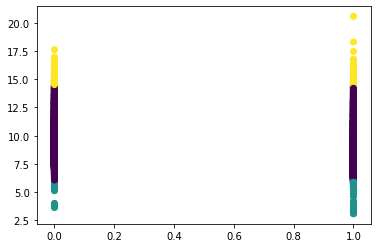

In [23]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

In [24]:
score = metrics.calinski_harabasz_score(X_train, labels)
score

1950.5713362122253

In [25]:
s_score = metrics.silhouette_score(X_train, labels, metric='euclidean')
s_score

0.24146203950628375

### K-Means

based on the results back from these two metrics, I would pick K-Means over Mean Shift. With that in mind, let's check out what those clusters tell us about the groups of runners picked by K-Means. 

In [34]:
data['class'] = Kmeans.predict(X_pca)

In [36]:
data.head()

,10k,name,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k,gender_M,class
0,17.37,"Yamamoto, Hiroyuki",8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1,2
1,32.58,"Jeptoo, Rita",1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,0,2
2,16.62,"Van Dyk, Ernst F.",1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1,2
3,32.57,"Dibaba, Mare",3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,0,2
4,17.12,"Hokinoue, Kota",2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1,2


In [50]:
data.groupby(['gender_M', 'class']).official.agg(['min', 'mean', 'max', 'std', 'var', 'count'])

min        mean     max        std         var  count
gender_M class                                                          
0        0      287.97  326.005692  461.87  29.389411  863.737463   3041
         1      221.57  248.726795  287.95  18.764376  352.101811   7191
         2       95.10  206.349545  221.55  13.028777  169.749041   3932
1        0      287.10  323.880216  538.88  29.979873  898.792811   2876
         1      225.48  252.219279  287.07  17.729437  314.332950   5147
         2       80.60  194.094542  225.48  19.146476  366.587531   9461

#### From this table we can see the descriptive statistics of the runners the clusters selected, separated by gender. 

